In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as data # pip install pandas_datareader
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
start = '2021-11-10' # 상장날 2021.11.10
end = '2022-03-18'

df = data.DataReader('RIVN.US','stooq', start, end) 
df.to_csv('Rivian.csv')

### 데이터 수집

In [3]:
df = pd.read_csv("/content/Rivian.csv")
df

,Date,Open,High,Low,Close,Volume
0,2022-03-17,40.840,42.7500,38.52,42.13,17167200
1,2022-03-16,38.500,42.0998,37.65,41.58,23752157
2,2022-03-15,35.670,37.3200,33.46,37.00,19671319
3,2022-03-14,37.740,37.7400,34.90,35.83,20756413
4,2022-03-11,38.360,41.0000,37.50,38.05,42597909
...,...,...,...,...,...,...
83,2021-11-16,163.800,179.4699,153.78,172.01,94036577
84,2021-11-15,130.800,152.5300,127.51,149.36,64982343
85,2021-11-12,128.645,135.2000,125.25,129.95,50636796
86,2021-11-11,114.625,125.0000,108.01,122.99,83668202


In [4]:
df.info() # Date object(문자) -> 숫자로 변경

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    88 non-null     object 
 1   Open    88 non-null     float64
 2   High    88 non-null     float64
 3   Low     88 non-null     float64
 4   Close   88 non-null     float64
 5   Volume  88 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.2+ KB


### 데이터 전처리

In [5]:
# datetime 자료형으로 변경
df['Date'] = pd.to_datetime(df['Date'])
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    88 non-null     datetime64[ns]
 1   Open    88 non-null     float64       
 2   High    88 non-null     float64       
 3   Low     88 non-null     float64       
 4   Close   88 non-null     float64       
 5   Volume  88 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 4.2 KB


In [6]:
# 요일정보 추가(월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6)
df['weekday'] = df['Date'].dt.weekday # 일봉
df  

,Date,Open,High,Low,Close,Volume,weekday
0,2022-03-17,40.840,42.7500,38.52,42.13,17167200,3
1,2022-03-16,38.500,42.0998,37.65,41.58,23752157,2
2,2022-03-15,35.670,37.3200,33.46,37.00,19671319,1
3,2022-03-14,37.740,37.7400,34.90,35.83,20756413,0
4,2022-03-11,38.360,41.0000,37.50,38.05,42597909,4
...,...,...,...,...,...,...,...
83,2021-11-16,163.800,179.4699,153.78,172.01,94036577,1
84,2021-11-15,130.800,152.5300,127.51,149.36,64982343,0
85,2021-11-12,128.645,135.2000,125.25,129.95,50636796,4
86,2021-11-11,114.625,125.0000,108.01,122.99,83668202,3


In [7]:
datetime

datetime.datetime

In [8]:
start = datetime(2005, 1, 3) # 월요일
df['weeks'] = (df["Date"] - start) // timedelta(weeks=1)  # 한주단위로 1씩 넘버링
df # 상장한지 얼마되지 않아 데이터가 많지 않음.

,Date,Open,High,Low,Close,Volume,weekday,weeks
0,2022-03-17,40.840,42.7500,38.52,42.13,17167200,3,897
1,2022-03-16,38.500,42.0998,37.65,41.58,23752157,2,897
2,2022-03-15,35.670,37.3200,33.46,37.00,19671319,1,897
3,2022-03-14,37.740,37.7400,34.90,35.83,20756413,0,897
4,2022-03-11,38.360,41.0000,37.50,38.05,42597909,4,896
...,...,...,...,...,...,...,...,...
83,2021-11-16,163.800,179.4699,153.78,172.01,94036577,1,880
84,2021-11-15,130.800,152.5300,127.51,149.36,64982343,0,880
85,2021-11-12,128.645,135.2000,125.25,129.95,50636796,4,879
86,2021-11-11,114.625,125.0000,108.01,122.99,83668202,3,879


In [9]:
df = df[["Date", "weeks", "weekday", "High", "Low", "Open", "Close"]]
df

,Date,weeks,weekday,High,Low,Open,Close
0,2022-03-17,897,3,42.7500,38.52,40.840,42.13
1,2022-03-16,897,2,42.0998,37.65,38.500,41.58
2,2022-03-15,897,1,37.3200,33.46,35.670,37.00
3,2022-03-14,897,0,37.7400,34.90,37.740,35.83
4,2022-03-11,896,4,41.0000,37.50,38.360,38.05
...,...,...,...,...,...,...,...
83,2021-11-16,880,1,179.4699,153.78,163.800,172.01
84,2021-11-15,880,0,152.5300,127.51,130.800,149.36
85,2021-11-12,879,4,135.2000,125.25,128.645,129.95
86,2021-11-11,879,3,125.0000,108.01,114.625,122.99


In [10]:
# 가장 오래된 날짜를 먼저 표시되도록 정렬
df.sort_values(by="Date", ascending=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [11]:
# Date컬럼을 인덱스로 변경
df.set_index(keys="Date", inplace=True)
df

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2021-11-10,879,2,119.4600,95.20,106.750,100.73
2021-11-11,879,3,125.0000,108.01,114.625,122.99
2021-11-12,879,4,135.2000,125.25,128.645,129.95
2021-11-15,880,0,152.5300,127.51,130.800,149.36
2021-11-16,880,1,179.4699,153.78,163.800,172.01
...,...,...,...,...,...,...
2022-03-11,896,4,41.0000,37.50,38.360,38.05
2022-03-14,897,0,37.7400,34.90,37.740,35.83
2022-03-15,897,1,37.3200,33.46,35.670,37.00


In [12]:
# 전일데이터 현재 데이터 차이 확인
df_shift = df.shift(-1)  # 한칸 올려용
df_shift

,weeks,weekday,High,Low,Open,Close
Date,,,,,,
2021-11-10,879.0,3.0,125.0000,108.01,114.625,122.99
2021-11-11,879.0,4.0,135.2000,125.25,128.645,129.95
2021-11-12,880.0,0.0,152.5300,127.51,130.800,149.36
2021-11-15,880.0,1.0,179.4699,153.78,163.800,172.01
2021-11-16,880.0,2.0,163.0000,140.35,160.880,146.07
...,...,...,...,...,...,...
2022-03-11,897.0,0.0,37.7400,34.90,37.740,35.83
2022-03-14,897.0,1.0,37.3200,33.46,35.670,37.00
2022-03-15,897.0,2.0,42.0998,37.65,38.500,41.58


In [13]:
df["Gap_Close"] = df_shift["Close"] - df["Close"] # 전날 종가와 오늘 종가의 차이
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,weeks,weekday,High,Low,Open,Close,Gap_Close
Date,,,,,,,
2021-11-10,879,2,119.4600,95.20,106.750,100.73,22.26
2021-11-11,879,3,125.0000,108.01,114.625,122.99,6.96
2021-11-12,879,4,135.2000,125.25,128.645,129.95,19.41
2021-11-15,880,0,152.5300,127.51,130.800,149.36,22.65
2021-11-16,880,1,179.4699,153.78,163.800,172.01,-25.94
...,...,...,...,...,...,...,...
2022-03-11,896,4,41.0000,37.50,38.360,38.05,-2.22
2022-03-14,897,0,37.7400,34.90,37.740,35.83,1.17
2022-03-15,897,1,37.3200,33.46,35.670,37.00,4.58


In [14]:
# 새로운 컬럼 up을 추가하고, 올라갈 경우 1, 내려갈 경우 0
# Gap_close 삭제 
df["Up"] = df["Gap_Close"].apply(lambda x:1 if x>=0 else 0)
df.drop(["Gap_Close"], axis =1, inplace=True)
df

# 방법 2
# # df["Up"] = (df["Gap_Close"] > 0).astype(int)
# # df.drop("Gap_Close", axis=1, inplace=True)
# # df


,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2021-11-10,879,2,119.4600,95.20,106.750,100.73,1
2021-11-11,879,3,125.0000,108.01,114.625,122.99,1
2021-11-12,879,4,135.2000,125.25,128.645,129.95,1
2021-11-15,880,0,152.5300,127.51,130.800,149.36,1
2021-11-16,880,1,179.4699,153.78,163.800,172.01,0
...,...,...,...,...,...,...,...
2022-03-11,896,4,41.0000,37.50,38.360,38.05,0
2022-03-14,897,0,37.7400,34.90,37.740,35.83,1
2022-03-15,897,1,37.3200,33.46,35.670,37.00,1


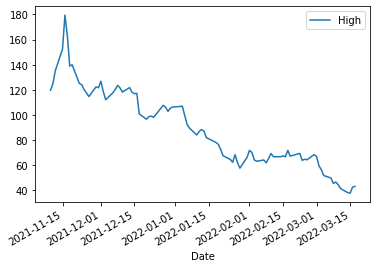

In [15]:
df_new = df[["High"]]
df_new.plot(kind="line")

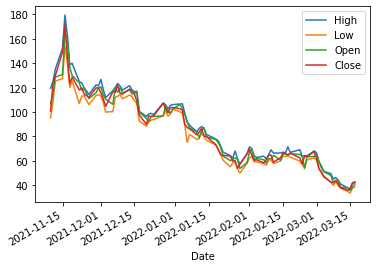

In [16]:
df_new = df[["High","Low", "Open", "Close"]]
df_new.plot(kind="line")

In [17]:
df_shift = df.shift(1) # 한칸 내려용
df_shift

,weeks,weekday,High,Low,Open,Close,Up
Date,,,,,,,
2021-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-11,879.0,2.0,119.4600,95.20,106.750,100.73,1.0
2021-11-12,879.0,3.0,125.0000,108.01,114.625,122.99,1.0
2021-11-15,879.0,4.0,135.2000,125.25,128.645,129.95,1.0
2021-11-16,880.0,0.0,152.5300,127.51,130.800,149.36,1.0
...,...,...,...,...,...,...,...
2022-03-11,896.0,3.0,44.1900,39.77,44.120,41.16,0.0
2022-03-14,896.0,4.0,41.0000,37.50,38.360,38.05,0.0
2022-03-15,897.0,0.0,37.7400,34.90,37.740,35.83,1.0


In [18]:
df["Close_ratio"] = (df["Close"]- df_shift["Close"]) / df_shift["Close"]  # 값이 어느정도 증가했는지 비율로 표시
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio
Date,,,,,,,,
2021-11-10,879,2,119.4600,95.20,106.750,100.73,1,NaN
2021-11-11,879,3,125.0000,108.01,114.625,122.99,1,0.220987
2021-11-12,879,4,135.2000,125.25,128.645,129.95,1,0.056590
2021-11-15,880,0,152.5300,127.51,130.800,149.36,1,0.149365
2021-11-16,880,1,179.4699,153.78,163.800,172.01,0,0.151647
...,...,...,...,...,...,...,...,...
2022-03-11,896,4,41.0000,37.50,38.360,38.05,0,-0.075559
2022-03-14,897,0,37.7400,34.90,37.740,35.83,1,-0.058344
2022-03-15,897,1,37.3200,33.46,35.670,37.00,1,0.032654


In [19]:
df["Body"] = df["Open"]- df["Close"] # 시작가와 종가의 차이
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body
Date,,,,,,,,,
2021-11-10,879,2,119.4600,95.20,106.750,100.73,1,NaN,6.020
2021-11-11,879,3,125.0000,108.01,114.625,122.99,1,0.220987,-8.365
2021-11-12,879,4,135.2000,125.25,128.645,129.95,1,0.056590,-1.305
2021-11-15,880,0,152.5300,127.51,130.800,149.36,1,0.149365,-18.560
2021-11-16,880,1,179.4699,153.78,163.800,172.01,0,0.151647,-8.210
...,...,...,...,...,...,...,...,...,...
2022-03-11,896,4,41.0000,37.50,38.360,38.05,0,-0.075559,0.310
2022-03-14,897,0,37.7400,34.90,37.740,35.83,1,-0.058344,1.910
2022-03-15,897,1,37.3200,33.46,35.670,37.00,1,0.032654,-1.330


### 주가예측을 위한 LSTM 모델 작성

In [20]:
list_weeks = []
list_weeks = df["weeks"].unique()
list_weeks # 주에 해당하는 번호값을 리스트형태로 저장

array([879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891,
       892, 893, 894, 895, 896, 897])

In [21]:
# 각 주 별로 휴장기간 때문 일 수가 몇일씩인지 확인
df["week_days"] = 0
for i in list_weeks:
  df["week_days"][df["weeks"] == i] = len(df[df["weeks"]==i]) # len(df[df["weeks"]==i 총 다섯개가 있으니까 5개씩 나눠져요

df
                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2021-11-10,879,2,119.4600,95.20,106.750,100.73,1,NaN,6.020,3
2021-11-11,879,3,125.0000,108.01,114.625,122.99,1,0.220987,-8.365,3
2021-11-12,879,4,135.2000,125.25,128.645,129.95,1,0.056590,-1.305,3
2021-11-15,880,0,152.5300,127.51,130.800,149.36,1,0.149365,-18.560,5
2021-11-16,880,1,179.4699,153.78,163.800,172.01,0,0.151647,-8.210,5
...,...,...,...,...,...,...,...,...,...,...
2022-03-11,896,4,41.0000,37.50,38.360,38.05,0,-0.075559,0.310,5
2022-03-14,897,0,37.7400,34.90,37.740,35.83,1,-0.058344,1.910,4
2022-03-15,897,1,37.3200,33.46,35.670,37.00,1,0.032654,-1.330,4


In [22]:
df[df["week_days"] < 4]

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2021-11-10,879,2,119.46,95.20,106.750,100.73,1,NaN,6.020,3
2021-11-11,879,3,125.00,108.01,114.625,122.99,1,0.220987,-8.365,3
2021-11-12,879,4,135.20,125.25,128.645,129.95,1,0.056590,-1.305,3


In [23]:
# 주 5일인 데이터 추출
df = df[df["week_days"] ==5]
df

,weeks,weekday,High,Low,Open,Close,Up,Close_ratio,Body,week_days
Date,,,,,,,,,,
2021-11-15,880,0,152.5300,127.51,130.80,149.36,1,0.149365,-18.56,5
2021-11-16,880,1,179.4699,153.78,163.80,172.01,0,0.151647,-8.21,5
2021-11-17,880,2,163.0000,140.35,160.88,146.07,0,-0.150805,14.81,5
2021-11-18,880,3,138.7800,120.15,136.81,123.38,1,-0.155336,13.43,5
2021-11-19,880,4,139.9000,125.60,129.98,128.60,0,0.042308,1.38,5
...,...,...,...,...,...,...,...,...,...,...
2022-03-07,896,0,49.4400,42.28,48.00,42.43,0,-0.104663,5.57,5
2022-03-08,896,1,45.0600,39.86,41.89,42.21,1,-0.005185,-0.32,5
2022-03-09,896,2,46.2500,42.69,43.39,43.95,0,0.041222,-0.56,5


In [24]:
df = df[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body', 'Up']]
df

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2021-11-15,0,152.5300,127.51,130.80,149.36,0.149365,-18.56,1
2021-11-16,1,179.4699,153.78,163.80,172.01,0.151647,-8.21,0
2021-11-17,2,163.0000,140.35,160.88,146.07,-0.150805,14.81,0
2021-11-18,3,138.7800,120.15,136.81,123.38,-0.155336,13.43,1
2021-11-19,4,139.9000,125.60,129.98,128.60,0.042308,1.38,0
...,...,...,...,...,...,...,...,...
2022-03-07,0,49.4400,42.28,48.00,42.43,-0.104663,5.57,0
2022-03-08,1,45.0600,39.86,41.89,42.21,-0.005185,-0.32,1
2022-03-09,2,46.2500,42.69,43.39,43.95,0.041222,-0.56,0


### 학습데이터와 검증용데이터 분리

In [25]:
df_train = df['2021-11-11' : '2022-03-18'] # 이부분 잘못되면 첫줄 nan 
df_train

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2021-11-15,0,152.5300,127.51,130.80,149.36,0.149365,-18.56,1
2021-11-16,1,179.4699,153.78,163.80,172.01,0.151647,-8.21,0
2021-11-17,2,163.0000,140.35,160.88,146.07,-0.150805,14.81,0
2021-11-18,3,138.7800,120.15,136.81,123.38,-0.155336,13.43,1
2021-11-19,4,139.9000,125.60,129.98,128.60,0.042308,1.38,0
...,...,...,...,...,...,...,...,...
2022-03-07,0,49.4400,42.28,48.00,42.43,-0.104663,5.57,0
2022-03-08,1,45.0600,39.86,41.89,42.21,-0.005185,-0.32,1
2022-03-09,2,46.2500,42.69,43.39,43.95,0.041222,-0.56,0


In [26]:
df_test = df['2021-11-15' : ]
df_test

,weekday,High,Low,Open,Close,Close_ratio,Body,Up
Date,,,,,,,,
2021-11-15,0,152.5300,127.51,130.80,149.36,0.149365,-18.56,1
2021-11-16,1,179.4699,153.78,163.80,172.01,0.151647,-8.21,0
2021-11-17,2,163.0000,140.35,160.88,146.07,-0.150805,14.81,0
2021-11-18,3,138.7800,120.15,136.81,123.38,-0.155336,13.43,1
2021-11-19,4,139.9000,125.60,129.98,128.60,0.042308,1.38,0
...,...,...,...,...,...,...,...,...
2022-03-07,0,49.4400,42.28,48.00,42.43,-0.104663,5.57,0
2022-03-08,1,45.0600,39.86,41.89,42.21,-0.005185,-0.32,1
2022-03-09,2,46.2500,42.69,43.39,43.95,0.041222,-0.56,0


In [27]:
X_train = df_train[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
Y_train = df_train['Up']

print(X_train)
print(Y_train)

            weekday      High     Low    Open   Close  Close_ratio   Body
Date                                                                     
2021-11-15        0  152.5300  127.51  130.80  149.36     0.149365 -18.56
2021-11-16        1  179.4699  153.78  163.80  172.01     0.151647  -8.21
2021-11-17        2  163.0000  140.35  160.88  146.07    -0.150805  14.81
2021-11-18        3  138.7800  120.15  136.81  123.38    -0.155336  13.43
2021-11-19        4  139.9000  125.60  129.98  128.60     0.042308   1.38
...             ...       ...     ...     ...     ...          ...    ...
2022-03-07        0   49.4400   42.28   48.00   42.43    -0.104663   5.57
2022-03-08        1   45.0600   39.86   41.89   42.21    -0.005185  -0.32
2022-03-09        2   46.2500   42.69   43.39   43.95     0.041222  -0.56
2022-03-10        3   44.1900   39.77   44.12   41.16    -0.063481   2.96
2022-03-11        4   41.0000   37.50   38.36   38.05    -0.075559   0.31

[65 rows x 7 columns]
Date
2021-11-15

In [28]:
X_test = df_test[['weekday', 'High', 'Low', 'Open', 'Close', 'Close_ratio', 'Body']]
Y_test = df_test['Up']

print(X_train)
print(Y_train)

            weekday      High     Low    Open   Close  Close_ratio   Body
Date                                                                     
2021-11-15        0  152.5300  127.51  130.80  149.36     0.149365 -18.56
2021-11-16        1  179.4699  153.78  163.80  172.01     0.151647  -8.21
2021-11-17        2  163.0000  140.35  160.88  146.07    -0.150805  14.81
2021-11-18        3  138.7800  120.15  136.81  123.38    -0.155336  13.43
2021-11-19        4  139.9000  125.60  129.98  128.60     0.042308   1.38
...             ...       ...     ...     ...     ...          ...    ...
2022-03-07        0   49.4400   42.28   48.00   42.43    -0.104663   5.57
2022-03-08        1   45.0600   39.86   41.89   42.21    -0.005185  -0.32
2022-03-09        2   46.2500   42.69   43.39   43.95     0.041222  -0.56
2022-03-10        3   44.1900   39.77   44.12   41.16    -0.063481   2.96
2022-03-11        4   41.0000   37.50   38.36   38.05    -0.075559   0.31

[65 rows x 7 columns]
Date
2021-11-15

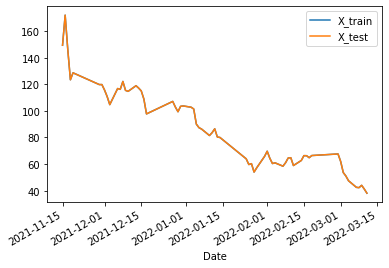

<Figure size 1440x1080 with 0 Axes>

In [29]:
X_train["Close"].plot(kind='line')
X_test["Close"].plot(kind='line')

plt.legend(['X_train', 'X_test'])
plt.figure(figsize=(20,15))
plt.show()

In [30]:
# 월~목 학습데이터, 정답데이터 → 월~ 목 까지 1set # 4일데이터를 가지고 5일치 데이터를 분석해야하기 때문에 4일씩 끊어요
# LSTM → Numpy 배열로 작업
# StandardScaler 사용
def Scaler_to_np(df):
  df_list = []
  df = np.array(df)
  for i in range(0, len(df)-3, 4):  # len(df)-34개씩 자르면 잘리는 부분 방지, 4는 간격
    df_s = df[i: i + 4]
    scaler = StandardScaler()
    df_scaler = scaler.fit_transform(df_s)
    df_list.append(df_scaler)

  return np.array(df_list)

In [31]:
# for i in range(0, 50-3, 4):  # len(df)-34개씩 자르면 잘리는 부분 방지, 4는 간격
#     print(i)

In [32]:
X_train_array = Scaler_to_np(X_train)
X_test_array = Scaler_to_np(X_test)

print(X_train_array.shape)
print(X_test_array.shape)

(16, 4, 7)
(16, 4, 7)


In [33]:
print(X_train_array)

[[[-1.34164079 -0.39777317 -0.61928031 -1.19435708  0.09603887
    0.99241404 -1.32923731]
  [-0.4472136   1.41389458  1.4302937   1.08752358  1.41040765
    1.00744633 -0.60237924]
  [ 0.4472136   0.30631858  0.38249092  0.88561172 -0.09487828
   -0.98500487  1.01426548]
  [ 1.34164079 -1.32243999 -1.19350431 -0.77877821 -1.41156824
   -1.0148555   0.91735107]]

 [[ 1.52127766  1.66658674  1.72805448  1.62428693  1.62075042
    0.59305061  0.24481853]
  [-1.18321596 -0.72441151 -0.57602456 -1.10393587 -0.25122161
    1.25283954 -1.44578502]
  [-0.50709255 -0.82736667 -0.48000207 -0.32196118 -0.25334163
   -0.48991572 -0.1507189 ]
  [ 0.16903085 -0.11480856 -0.67202785 -0.19838988 -1.11618717
   -1.35597443  1.35168539]]

 [[ 0.63245553  0.46384538  0.50390349  0.31709174 -0.27216268
   -0.67829963  0.44741123]
  [ 1.26491106 -1.64468837 -0.97957307 -0.44310214 -1.52042759
   -0.86417095  0.82532927]
  [-1.26491106  0.1530129  -0.91831985 -1.29625453  0.95768521
    1.66664314 -1.71078

In [34]:
y_train_new = Y_train[3::4] 
y_test_new = Y_test[3::4]

print(len(y_train_new))
print(len(y_test_new))

16
16


### LSTM 모델 생성

In [35]:
def gen_lstm_compile(df):
  model = Sequential()
  model.add(LSTM(256, activation='tanh', batch_input_shape=(None, df.shape[1], df.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='tanh'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [36]:
# 시계열데이터 모델 검증하기(Timeseries Validation) -> TimeSeriesSplit
valid_scores = []  # 4번의 교차 검증의 결과 저장
tscv = TimeSeriesSplit(n_splits=4)

In [37]:
for fold, (train_indices, value_indices) in enumerate(tscv.split(X_train_array)): 
  print(fold)
  print(train_indices)
  print(value_indices)
  X_train, X_valid = X_train_array[train_indices], X_train_array[value_indices]
  y_train, y_valid = y_train_new[train_indices], y_train_new[value_indices]

0
[0 1 2 3]
[4 5 6]
1
[0 1 2 3 4 5 6]
[7 8 9]
2
[0 1 2 3 4 5 6 7 8 9]
[10 11 12]
3
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[13 14 15]


In [38]:
for fold, (train_indices, value_indices) in enumerate(tscv.split(X_train_array)): 
  X_train, X_valid = X_train_array[train_indices], X_train_array[value_indices]
  y_train, y_valid = y_train_new[train_indices], y_train_new[value_indices]

  model = gen_lstm_compile(X_train)
  model.fit(X_train, y_train, epochs=10, batch_size=32)

  y_pred = model.predict(X_valid)

  y_pred = np.where(y_pred < 0.5, 0, 1)

  score = accuracy_score(y_valid, y_pred)
  print(f"fold:{fold}, score:{score}")

  valid_scores.append(score)
  

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.7006 - accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 38ms/step - loss: 0.6873 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 42ms/step - loss: 0.6640 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 42ms/step - loss: 0.6644 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 40ms/step - loss: 0.6354 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 30ms/step - loss: 0.6291 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 36ms/step - loss: 0.6102 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 28ms/step - loss: 0.6024 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 31ms/step - loss: 0.5904 - accuracy: 0.7500
Epoch 10/10
1/1 [==============================] - 0s 36ms/step - loss: 0.5599 - accuracy: 1.0000
fold:0, score:1.0
Epoch 1/10
1/

In [39]:
print(f"valid_scores:{valid_scores}")
cv_score = np.mean(valid_scores)
print(f"cv_score: {cv_score}")

valid_scores:[1.0, 0.3333333333333333, 0.3333333333333333, 0.0]
cv_score: 0.41666666666666663


In [40]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',   
                   mode='auto', 
                   verbose=1, 
                   patience=5)

model = gen_lstm_compile(X_train_array)
r = model.fit(X_train_array, y_train_new, epochs=10, batch_size=32, callbacks=es, validation_split=0.1)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6962 - accuracy: 0.4286 - val_loss: 0.6825 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.6810 - accuracy: 0.7857 - val_loss: 0.6836 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 50ms/step - loss: 0.6707 - accuracy: 0.7143 - val_loss: 0.6879 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 49ms/step - loss: 0.6605 - accuracy: 0.6429 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 59ms/step - loss: 0.6449 - accuracy: 0.7143 - val_loss: 0.6990 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 50ms/step - loss: 0.6350 - accuracy: 0.7857 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 6: early stopping


In [42]:
pred = model.predict(X_test_array)
pred[:10] # 10개 까지만 확인

array([[0.481734  ],
       [0.40113124],
       [0.53214854],
       [0.4622582 ],
       [0.4385295 ],
       [0.5434799 ],
       [0.36103246],
       [0.45728558],
       [0.3884467 ],
       [0.50772595]], dtype=float32)

In [43]:
pred = np.where(pred<0.5,0,1)
pred[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1]])

In [44]:
print(f"accuracy={accuracy_score(y_true=y_test_new, y_pred=pred)}")

accuracy=0.75


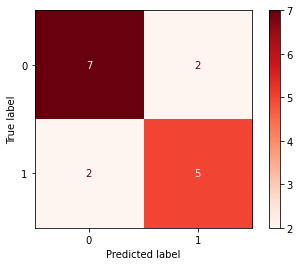

In [45]:
cm = confusion_matrix(y_test_new, pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)